In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick, candlestick2 
import matplotlib.dates as mdates
import ml_metrics, string, re, pylab as pl

from sklearn import feature_extraction
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%matplotlib inline

In [130]:
#saving vars
dataFolder = '../data/'
fileName = 'EURUSD-ticks.csv'
maSettings = (8, 25,50,120)
macdSettings = ([26,12],[55,25])
compareShift = (1,5,10,50)
#compareCandles = (1,2,3,4,5,10,15,25,50,100)
timeFrame = ('10Min')
maxNumber = max(maSettings)+ max(compareShift)+2
maxNumber

172

In [131]:
# load data from csv. nrows=1000 (limits rows to be loaded)
data = pd.read_csv(dataFolder+fileName, nrows = 100000000000, parse_dates=True, index_col=0)
data.head(2)

,ask,bid,spread
date,,,
2013-04-26 15:11:09.298,1.30252,1.30247,0.00005
2013-04-26 15:11:09.298,1.30252,1.30247,0.00005


In [132]:
data.tail(2)

,ask,bid,spread
date,,,
2015-09-29 23:59:49.794,1.12534,1.12532,0.00002
2015-09-29 23:59:53.413,1.12534,1.12533,0.00001


In [133]:
#drop useless columns
data.drop(['ask', 'spread'], axis=1, inplace = True)
data.head(2)

,bid
date,
2013-04-26 15:11:09.298,1.30247
2013-04-26 15:11:09.298,1.30247


In [134]:
# resample to OHLC
m5 = data['bid'].resample(timeFrame, how='ohlc').dropna()
m5.head(3)

,open,high,low,close
date,,,,
2013-04-26 15:10:00,1.30247,1.30354,1.30247,1.30269
2013-04-26 15:20:00,1.30270,1.30275,1.30224,1.30260
2013-04-26 15:30:00,1.30262,1.30268,1.30210,1.30215


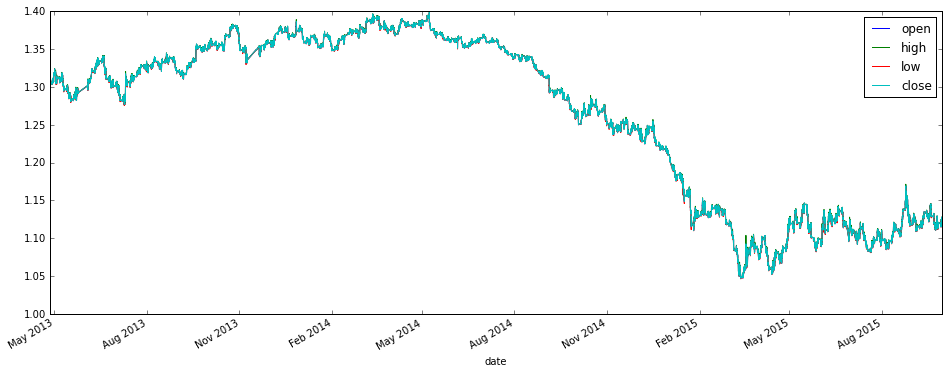

In [135]:
m5.plot(figsize=(16,6))

In [136]:
#reindexing to id's
m5.insert(0,'date', m5.index)
m5['id'] = list(range(len(m5.index)))
m5.set_index('id', drop=False, inplace = True)
m5.drop('id', axis = 1, inplace = 1)
m5.head(2)

,date,open,high,low,close
id,,,,,
0,2013-04-26 15:10:00,1.30247,1.30354,1.30247,1.30269
1,2013-04-26 15:20:00,1.30270,1.30275,1.30224,1.30260


In [137]:
# add current candle move
m5['move'] = m5['close']-m5['open']
# add label. 0 = red, 1 = green candle
m5['label'] =  (m5['close'] - m5['open']).apply(lambda l: 0 if l < 0 else 1)
m5.head(2)

,date,open,high,low,close,move,label
id,,,,,,,
0,2013-04-26 15:10:00,1.30247,1.30354,1.30247,1.30269,0.00022,1
1,2013-04-26 15:20:00,1.30270,1.30275,1.30224,1.30260,-0.00010,0


In [138]:
# function that computes EMA
def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1,0,window))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

In [139]:
# calculate ma for each MA in the maSettings turple
for i in maSettings:
    name = 'ema'+str(i)
    m5[name] = ExpMovingAverage(m5.close, i)
    # calculate ma shoft for each shift bar ([current bar] - [current bar- n bars])
    for n in compareShift:
        m5[name+'Shift_'+str(n)] = m5[name] - m5.shift(periods = n)[name]
    #drop computed ma columns
    m5.drop(name, axis = 1, inplace = 1 )
m5.head(3)

,date,open,high,low,close,move,label,ema8Shift_1,ema8Shift_5,ema8Shift_10,...,ema25Shift_10,ema25Shift_50,ema50Shift_1,ema50Shift_5,ema50Shift_10,ema50Shift_50,ema120Shift_1,ema120Shift_5,ema120Shift_10,ema120Shift_50
id,,,,,,,,,,,,,,,,,,,,,
0,2013-04-26 15:10:00,1.30247,1.30354,1.30247,1.30269,0.00022,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-26 15:20:00,1.30270,1.30275,1.30224,1.30260,-0.00010,0,0,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
2,2013-04-26 15:30:00,1.30262,1.30268,1.30210,1.30215,-0.00047,0,0,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN


In [140]:
#function to compute macd
def computeMACD(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow

In [141]:
# calculate macd for each macd on the macdSettings(2d) turple
for fast, slow in macdSettings:
    name = 'macd'+str(fast)+'_'+str(slow)
    _, _, macd = computeMACD(m5.close, slow, fast)
    #m5['emaslow'+str(fast)+'_'+str(slow)] = emaslow
    #m5['emafast'+str(fast)+'_'+str(slow)] = emafast
    m5[name] = macd
    # calculate shift for each
    for n in compareShift: 
        m5[name+'Shift_'+str(n)] = m5[name] - m5.shift(periods = n)[name];
m5.shape

(87259, 33)

In [142]:
np.count_nonzero(m5.open)

87259

In [143]:
#m5.columns[6:]

In [144]:
m5[m5.columns[7:]][115:125]

,ema8Shift_1,ema8Shift_5,ema8Shift_10,ema8Shift_50,ema25Shift_1,ema25Shift_5,ema25Shift_10,ema25Shift_50,ema50Shift_1,ema50Shift_5,...,macd26_12,macd26_12Shift_1,macd26_12Shift_5,macd26_12Shift_10,macd26_12Shift_50,macd55_25,macd55_25Shift_1,macd55_25Shift_5,macd55_25Shift_10,macd55_25Shift_50
id,,,,,,,,,,,,,,,,,,,,,
115,-0.000051,-0.000261,-0.000416,0.003947,0.000152,0.000936,0.001749,0.003431,0.000062,0.000299,...,-0.000791,0.000269,0.001268,0.001108,-0.001214,-0.001982,-8.833118e-05,-0.000577,-0.001001,-0.001082
116,-0.000149,-0.000302,-0.000572,0.003620,0.000127,0.000881,0.001745,0.003644,0.000056,0.000298,...,-0.000619,0.000172,0.001267,0.001421,-0.000792,-0.002049,-6.659754e-05,-0.000536,-0.000995,-0.001276
117,-0.000129,-0.000385,-0.000759,0.003370,0.000113,0.000806,0.001711,0.003794,0.000054,0.000287,...,-0.000466,0.000154,0.001129,0.001744,-0.000379,-0.002098,-4.969532e-05,-0.000477,-0.000967,-0.001402
118,0.000022,-0.000296,-0.000648,0.003323,0.000136,0.000740,0.001672,0.003956,0.000056,0.000278,...,-0.000367,0.000098,0.000979,0.001872,-0.000123,-0.002166,-6.735137e-05,-0.000417,-0.000938,-0.001531
119,0.000049,-0.000259,-0.000576,0.003314,0.000134,0.000661,0.001621,0.004073,0.000053,0.000281,...,-0.000186,0.000182,0.000874,0.002046,0.000218,-0.002252,-8.668117e-05,-0.000359,-0.000933,-0.001644
120,0.000055,-0.000152,-0.000414,0.003297,0.000148,0.000658,0.001593,0.004216,0.000071,0.000291,...,0.000040,0.000226,0.000831,0.002099,0.000554,-0.002339,-8.694729e-05,-0.000357,-0.000934,-0.001768
121,0.000109,0.000106,-0.000196,0.003310,0.000072,0.000603,0.001484,0.004280,0.000072,0.000306,...,0.000244,0.000204,0.000863,0.002130,0.000830,-0.002355,-1.600401e-05,-0.000307,-0.000843,-0.001825
122,0.000023,0.000258,-0.000127,0.003382,0.000050,0.000541,0.001347,0.004323,0.000074,0.000327,...,0.000297,0.000053,0.000763,0.001892,0.000904,-0.002355,2.259966e-07,-0.000257,-0.000734,-0.001863
123,-0.000077,0.000159,-0.000137,0.003304,-0.000022,0.000382,0.001122,0.004265,0.000069,0.000339,...,0.000316,0.000019,0.000683,0.001662,0.000934,-0.002286,6.949643e-05,-0.000120,-0.000536,-0.001809


In [145]:
#remove empty rows (first many used to compute ma, macd & shift)
m5 = m5[maxNumber:]

In [146]:
m5.shape

(87087, 33)

In [147]:
m5.columns


Index([u'date', u'open', u'high', u'low', u'close', u'move', u'label',
       u'ema8Shift_1', u'ema8Shift_5', u'ema8Shift_10', u'ema8Shift_50',
       u'ema25Shift_1', u'ema25Shift_5', u'ema25Shift_10', u'ema25Shift_50',
       u'ema50Shift_1', u'ema50Shift_5', u'ema50Shift_10', u'ema50Shift_50',
       u'ema120Shift_1', u'ema120Shift_5', u'ema120Shift_10',
       u'ema120Shift_50', u'macd26_12', u'macd26_12Shift_1',
       u'macd26_12Shift_5', u'macd26_12Shift_10', u'macd26_12Shift_50',
       u'macd55_25', u'macd55_25Shift_1', u'macd55_25Shift_5',
       u'macd55_25Shift_10', u'macd55_25Shift_50'],
      dtype='object')

In [148]:
m5.columns[:6]

Index([u'date', u'open', u'high', u'low', u'close', u'move'], dtype='object')

In [149]:
#remove first 5 columns
m5.drop(m5.columns[:6], axis = 1, inplace = 1)
m5.shape

(87087, 27)

In [150]:
m5.columns[:]

Index([u'label', u'ema8Shift_1', u'ema8Shift_5', u'ema8Shift_10',
       u'ema8Shift_50', u'ema25Shift_1', u'ema25Shift_5', u'ema25Shift_10',
       u'ema25Shift_50', u'ema50Shift_1', u'ema50Shift_5', u'ema50Shift_10',
       u'ema50Shift_50', u'ema120Shift_1', u'ema120Shift_5', u'ema120Shift_10',
       u'ema120Shift_50', u'macd26_12', u'macd26_12Shift_1',
       u'macd26_12Shift_5', u'macd26_12Shift_10', u'macd26_12Shift_50',
       u'macd55_25', u'macd55_25Shift_1', u'macd55_25Shift_5',
       u'macd55_25Shift_10', u'macd55_25Shift_50'],
      dtype='object')

In [151]:
#m5.corr()

In [152]:
# finally we have a data
selected = m5.dropna()

In [153]:
#split features and labels
target = selected.label.values
train = selected.drop('label',axis=1).values
target.shape

(87087L,)

In [154]:
#prepaire  sklearn
coder = PCA()
#transform data
train  = coder.fit_transform(train)

In [155]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())

In [156]:
#split features
fTrain, fTest, lTrain, lTest = train_test_split(train, target, random_state = 0)

In [157]:
fTrain.shape

(65315L, 26L)

In [158]:
timeFrame

'10Min'

In [159]:
### DO the magic and see results

#plt.figure(figsize=(18,18))
for model in models:
    model.fit(fTrain,lTrain)
    score = model.score(fTest, lTest)
    print score
    #pred_scr = model.predict_proba(fTest)[:, 1]
    #fpr, tpr, thresholds = roc_curve(lTest, pred_scr)
    #roc_auc = ml_metrics.auc(lTrain, pred_scr)
    #md = str(model)
    #md= md[:md.find('(')]
    #plt.plot(fpr, tpr, label = 'Roc fold %s (auc = %0.2f)' %(md, roc_auc))
#plt.plot([0,1], [0,1], '--', color = (0.6, 0.6,0.6))
##plt.xlim([0,1])
#plt.ylim([0,1])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Predicting score for Candle relations')
#plt.legend(loc="lower right")
#plt.show()

0.579230203932
0.605410619144
0.492605180966
0.626033437443


In [98]:



'''
    EURUSD
    M15 27F
    0.610237306843
>>  0.618170529801
    0.487651766004
    0.605063465784

    GBPUSD
    m1, 27 features:
    0.540647558137
    0.551256789485
    0.509450022338
    0.553410613934

    GBPUSD
    m10, 27 features:
    0.600340057902
    0.620192086761
    0.492854188686
>>> 0.645466660539

    GBPUSD
    m30, 27 features:
    0.625448523323
    0.638697212255
>>> 0.482749102953
    0.621446315208

    GBPUSD
    m15, 27 features:
    0.623438470564
    0.638415349576
    0.489474773966
>>> 0.643522672372
'''

'\nm1, 27 features:\n0.540647558137\n0.551256789485\n0.509450022338\n0.553410613934\n\nm10, 27 features;\nm30, 27 features:\n0.625448523323\n0.638697212255\n0.482749102953\n0.621446315208\n\nm15, 27 features:\n0.623438470564\n0.638415349576\n0.489474773966\n0.643522672372\n'

In [ ]:
#model = models[0]

In [ ]:
#model.fit(fTrain, lTrain)

In [ ]:
#model.score(fTest, lTest)